In [521]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import csv

In [522]:
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

def split_df(dataframe, col_name, sep):
    orig_col_index = dataframe.columns.tolist().index(col_name)
    orig_index_name = dataframe.index.name
    orig_columns = dataframe.columns
    dataframe = dataframe.reset_index()  
    index_col_name = (set(dataframe.columns) - set(orig_columns)).pop()
    df_split = pd.DataFrame(
        pd.DataFrame(dataframe[col_name].str.split(sep).tolist())
        .stack().reset_index(level=1, drop=1), columns=[col_name])
    df = dataframe.drop(col_name, axis=1)
    df = pd.merge(df, df_split, left_index=True, right_index=True, how='inner')
    df = df.set_index(index_col_name)
    df.index.name = orig_index_name
    # merge adds the column to the last place, so we need to move it back
    return change_column_order(df, col_name, orig_col_index)



In [523]:
# Loading Data

df = pd.read_csv(r'enron-event-history-all.csv', header = None, low_memory=False)


In [532]:
# Assigning Column Names
df.columns = ['time', 'message_identifier', 'sender', 'recipients', 'topic', 'mode']
df = df.drop(columns=['topic', 'mode'])

print('Num. Rows:', df.shape[0], 'Num. Columns: ', df.shape[1])
df.head(5)


Num. Rows: 205731 Num. Columns:  4


,time,message_identifier,sender,recipients
0,896308260000,<GKNWYZTKAVMKBCTMA3ZZSQIBITG5OD1KA@zlsvr22>,Christopher Behney,Toni P Schulenburg|mary hain
1,909790980000,<N5QXQ4CHS04FBSJO3TALWRBXATDTIWZ0B@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com
2,909791760000,<FEJ0YLF5MHTTF2QHNWMRUODCCHDCPUA5A@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com
3,909792120000,<NFC21LWTHYCKD4JV1IQMLSQ4JX2WY1JCB@zlsvr22>,mark legal taylor,shari stack
4,909795960000,<LAGJQ1MQZ2HX3APYD2TBODXUA4XF04UOA@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com


In [533]:
# Reviewing general info of Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205731 entries, 0 to 205730
Data columns (total 4 columns):
time                  205731 non-null int64
message_identifier    205731 non-null object
sender                205731 non-null object
recipients            205731 non-null object
dtypes: int64(1), object(3)
memory usage: 6.3+ MB


In [534]:
# Replacing null values with blanks

df['recipients'] = df.recipients.fillna('')
df['sender'] = df.sender.fillna('')

df_new['sender'] = df_new['sender'].map(lambda x: x.strip())


In [535]:
# Column 'recipients' could have multiple emails separated by '|'. This function creates as many rows as emails
df_new = split_df(df, 'recipients', '|')

In [536]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435896 entries, 0 to 205730
Data columns (total 4 columns):
time                  435896 non-null int64
message_identifier    435896 non-null object
sender                435896 non-null object
recipients            435896 non-null object
dtypes: int64(1), object(3)
memory usage: 16.6+ MB


In [537]:
df_new['recipients'] = df_new['recipients'].map(lambda x: x.strip())

# Note:
# 'recipients'/'sender' have cases with single character values such as '-', '.', n', 'j', etc. They were left unchanged
# 'recipients'/sender have cases where the value contains 'undisclosed' or 'undisclosed recipients'. Without additional information, they were left unchanged


In [538]:
df_new.head(5)

,time,message_identifier,sender,recipients
0,896308260000,<GKNWYZTKAVMKBCTMA3ZZSQIBITG5OD1KA@zlsvr22>,Christopher Behney,Toni P Schulenburg
0,896308260000,<GKNWYZTKAVMKBCTMA3ZZSQIBITG5OD1KA@zlsvr22>,Christopher Behney,mary hain
1,909790980000,<N5QXQ4CHS04FBSJO3TALWRBXATDTIWZ0B@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com
2,909791760000,<FEJ0YLF5MHTTF2QHNWMRUODCCHDCPUA5A@zlsvr22>,mark legal taylor,Marc.R.Cutler@BankAmerica.com
3,909792120000,<NFC21LWTHYCKD4JV1IQMLSQ4JX2WY1JCB@zlsvr22>,mark legal taylor,shari stack


In [539]:
# Creating Outcome: Sender / Number Recipients / Number Emails Sent

Outcome_1 = df_new.groupby('sender', as_index=False).agg({"recipients": "nunique", "message_identifier": "nunique" })
Outcome_1 = Outcome_1.sort_values(by=['message_identifier'], ascending = False)
Outcome_1.columns = ['sender', 'number_recipients', 'number_emails_sent']
Outcome_1['row_num'] = Outcome_1.reset_index().index
Outcome_1.head(5)

,sender,number_recipients,number_emails_sent,row_num
6409,jeff dasovich,929,5230,0
12569,sara shackleton,958,4588,1
2349,chris germany,783,3697,2
10580,notes,183,3152,3
11141,pete davis,16,3124,4


In [540]:
# Converting Unix time to Date/Time format
df_new['time_new']=(pd.to_datetime(df_new['time'],unit='ms'))
df_new['time_quarter'] = df_new['time_new'].dt.to_period("Q")


In [541]:
# Number of Messages sent by Quarter

Outcome_2 = df_new.groupby(['sender','time_quarter'], as_index=False).agg({"recipients": "nunique", "message_identifier": "nunique" })
Outcome_2.columns = ['sender', 'quarter', 'recipients', 'emails sent']
Outcome_2.head(5)

,sender,quarter,recipients,emails sent
0,,2000Q3,1,2
1,,2000Q4,1,1
2,,2001Q1,6,6
3,,2001Q2,4,14
4,,2001Q4,11,7


In [542]:
# Selecting Only the most prolific Senders (top 5)
Graph_1 = pd.merge(Outcome_2[['sender','quarter','emails sent']], Outcome_1[['sender','row_num']][Outcome_1['row_num'] <= 4], on='sender', how='inner')
Graph_1 = Graph_1.sort_values(by=['row_num','quarter'], ascending = True)
Graph_1 = Graph_1.drop(columns=['row_num'])
Graph_1.head(5)

,sender,quarter,emails sent
12,jeff dasovich,1999Q4,1
13,jeff dasovich,2000Q1,1
14,jeff dasovich,2000Q2,3
15,jeff dasovich,2000Q3,435
16,jeff dasovich,2000Q4,996


In [543]:
# Outcome 1: A .csv file with three columns "person", "sent", "received", where the
# final two columns contain the number of emails that person sent or received in the data set. 
# This file should be sorted by the number of emails sent.

In [544]:
df_sent = df_new.groupby(['sender'], as_index=False).agg({"message_identifier": "nunique" })
df_sent.columns = ['person', 'sent']

In [545]:
df_received = df_new.groupby(['recipients'], as_index=False).agg({"message_identifier": "nunique" })
df_received.columns = ['person', 'received']

In [546]:
df_1 = df_sent.merge(df_received, how='outer', left_on=['person'], right_on=['person'])

df_1['sent'].fillna(0, inplace=True)
df_1['received'].fillna(0, inplace=True)
df_1 = df_1.sort_values(by=['sent'], ascending = False)
df_1.head(5)

,person,sent,received
6409,jeff dasovich,5230.0,2242.0
12569,sara shackleton,4588.0,5210.0
2349,chris germany,3697.0,1589.0
10580,notes,3152.0,888.0
11141,pete davis,3124.0,853.0


In [547]:
# Creating CSV file
df_1.to_csv("person_sent_received.csv", sep=",", float_format='%.2f',index=False, line_terminator='\n',encoding='utf-8')


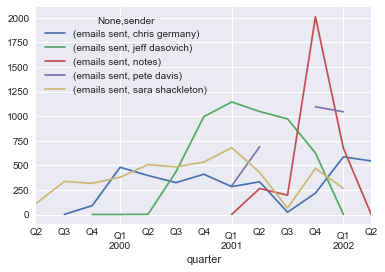

In [548]:
# 2. A PNG image visualizing the number of emails sent over time by some of the
#   most prolific senders in (1). There are no specific guidelines regarding the
#   format and specific content of the visualization---you can choose which and
#   how many senders to include, and the type of plot---but you should strive to
#   make it as clear and informative as possible, making sure to represent time
#   in some meaningful way.


# This Graph shows the 5 most prolific senders, showing the number of emails sent by quarter
# Importantly, it shows whether the number of emails sent increased or decreased at specific times

plt_graph_1 = Graph_1.groupby(['quarter','sender']).sum().unstack().plot()
fig = plt_graph_1.get_figure()
fig.savefig('enron_graph_1.png')

In [550]:

# Identifyng cases where the 5 most prolific senders were the recipient of email and counting number of unique senders 

# Selecting Only the most 10 prolific Senders
df_recip = pd.merge(Outcome_1[['sender','row_num']][Outcome_1['row_num'] <= 4], df_new, left_on='sender', right_on = 'recipients', how='inner')
df_recip = df_recip.drop(columns=['sender_x','row_num','time', 'time_new'])
df_recip.columns = ['message_identifier', 'sender', 'recipients', 'quarter']
df_recip.head(5)

,message_identifier,sender,recipients,quarter
0,<P2E4GOIJJ3AMWQLL1VFVBIEQCOKV3PXAB@zlsvr22>,Martin.Esarte@clorox.com,jeff dasovich,1999Q3
1,<CMOJRFKLNSY30A3AOBGMCKLAOI5X1ABNB@zlsvr22>,hudacko,jeff dasovich,1999Q3
2,<PG5U0E0ROCKGW5RPMGY4CUPMUKCATJFWB@zlsvr22>,mark mcclelland,jeff dasovich,1999Q3
3,<PBWJ51PORXNX2J0HISGDZN5SUIPRPOKXB@zlsvr22>,orders amazon,jeff dasovich,1999Q3
4,<E3M4IJ2YZYZHUR0U1UK2QCJ0MICJF3S2B@zlsvr22>,orders amazon,jeff dasovich,1999Q3


In [551]:
# 3. A visualization that shows, for the same people, the number of unique
#   people/email addresses who contacted them over the same time period. The raw
#   number of unique incoming contacts is not quite as important as the relative
#   numbers (compared across the individuals from (2) ) and how they change over
#   time.


Graph_2 = df_recip.groupby(['recipients', 'quarter'], as_index=False).agg({"sender": "nunique" })
Graph_2.columns = ['top senders', 'quarter', 'num contacts']


In [552]:
Graph_2.head(5)

,top senders,quarter,num contacts
0,chris germany,1999Q3,1
1,chris germany,1999Q4,7
2,chris germany,2000Q1,50
3,chris germany,2000Q2,33
4,chris germany,2000Q3,28


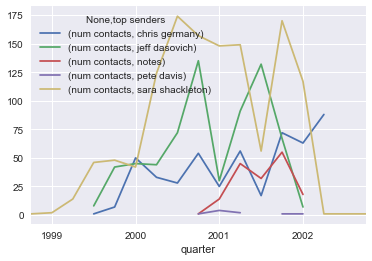

In [553]:
plt_graph_2 = Graph_2.groupby(['quarter','top senders']).sum().unstack().plot()

fig = plt_graph_2.get_figure()
fig.savefig('enron_graph_2.png')